# Visualising convnets: intermediate activations

In a deep neural network, the first few layers learn some basic features of the input data. This could be horizontal / vertical edges, circles and other basic shapes in the case of ConvNets, or basic sounds in the case of RNNs applied to audio data. As the signal propagates through the network, more complex forms are found, such as eyes, ears, contours in the case of ConvNets, or phonems, or even short words in the case of RNNs. In this part we'll look at the activations of a ConvNet, previously trained on the Dogs and Cats dataset. Look at notebook `4_convnets_augmentation_dogscats.ipynb` for details how it was trained. 

Let's start by loading the model and printing its detials.

In [47]:
from keras.models import load_model
model = load_model('convnet_augm_dogs_cats.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

Here we're interested in visualising the activations of all Conv and MaxPool layers in the network. We can select a single image from the test set (which the model was not trained on), pass it through the network and look at the activations.

In [48]:
import os
img_path = os.getcwd() + "/../data/DogsCatsData/test/cats/cat.1752.jpg"

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
print(img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
print(img_tensor.shape)
img_tensor /= 255  # the following imshow wouldn't work without this normalization

(150, 150, 3)
(1, 150, 150, 3)


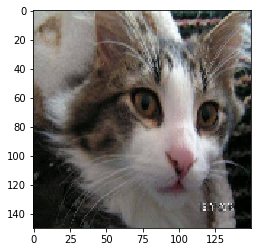

In [49]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

To collect the activations of all the layers in the network, we can use the `Model` class of keras and pass in the input and output arguments to it. The outputs will actually now represent a list of the activations of all layers.

In [22]:
from keras import models

In [50]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

Now we can pass the image through the model and obtain our list of activations..

In [51]:
activations = activation_model.predict(img_tensor)

We can plot a few different channels of the first activation of the model. They all show a different activation, meaning they're detecting different details of the image (eg. vertical edges, horizontal edges, round forms, etc..)

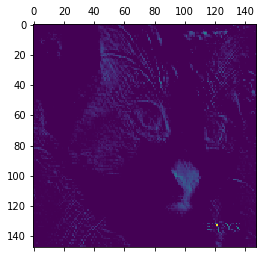

In [59]:
def plot_channel(channel_num=0):
    '''
    Plots the channel with number `channel_num` of the first activation in the model (layer 1)
    '''
    layer1_activation = activations[0][0, :, :, channel_num]
    layer1_activation.shape  # (148, 148)
#     plt.imshow(layer1_activation)
    plt.matshow(layer1_activation, cmap='viridis')
    plt.show()

plot_channel(8)

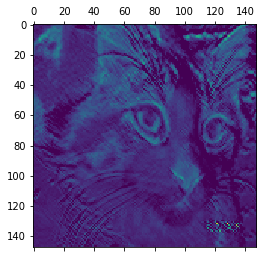

In [56]:
plot_channel(9)

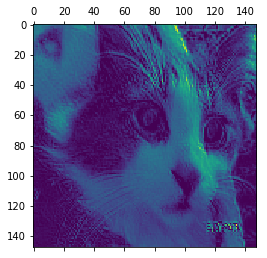

In [58]:
plot_channel(10)

Even better, we can plot all channels of all activations in the model together. Here channels are plotted side-by-side.

(1, 148, 148, 32) conv2d_9
big_image.shape: (296, 2368)


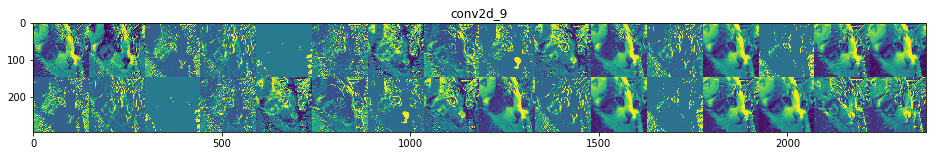

(1, 74, 74, 32) max_pooling2d_9
big_image.shape: (148, 1184)


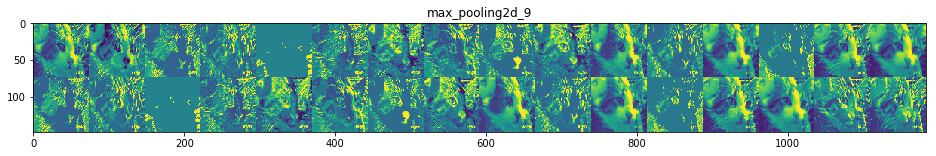

(1, 72, 72, 64) conv2d_10
big_image.shape: (288, 1152)


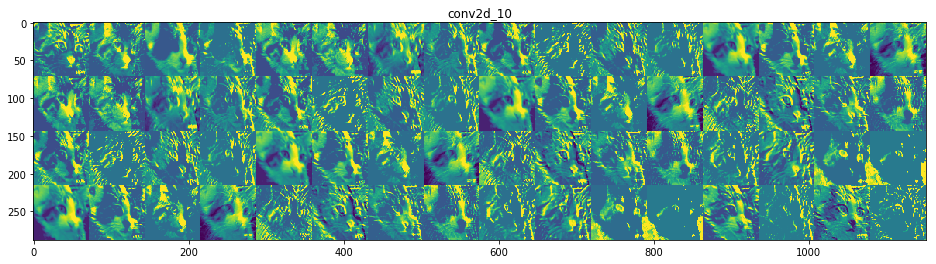

(1, 36, 36, 64) max_pooling2d_10
big_image.shape: (144, 576)


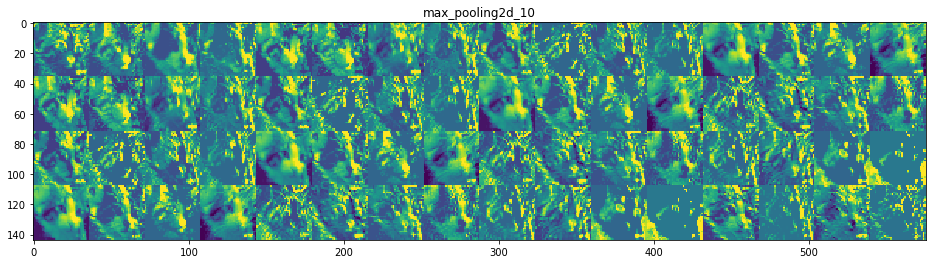

(1, 34, 34, 128) conv2d_11
big_image.shape: (272, 544)


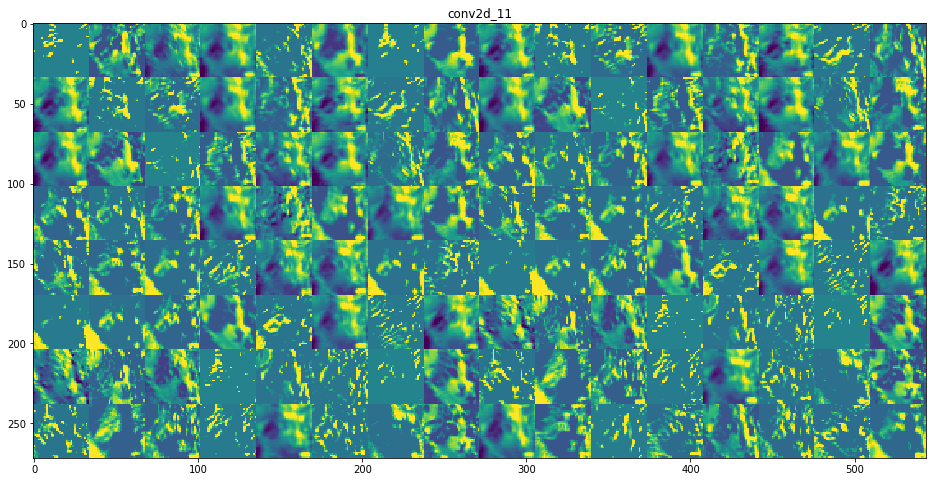

(1, 17, 17, 128) max_pooling2d_11
big_image.shape: (136, 272)


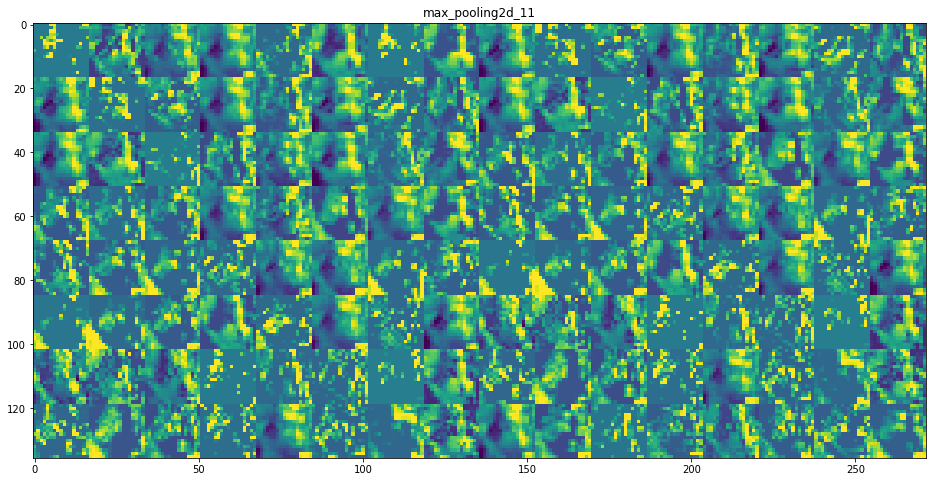

(1, 15, 15, 128) conv2d_12
big_image.shape: (120, 240)


/Users/Misko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


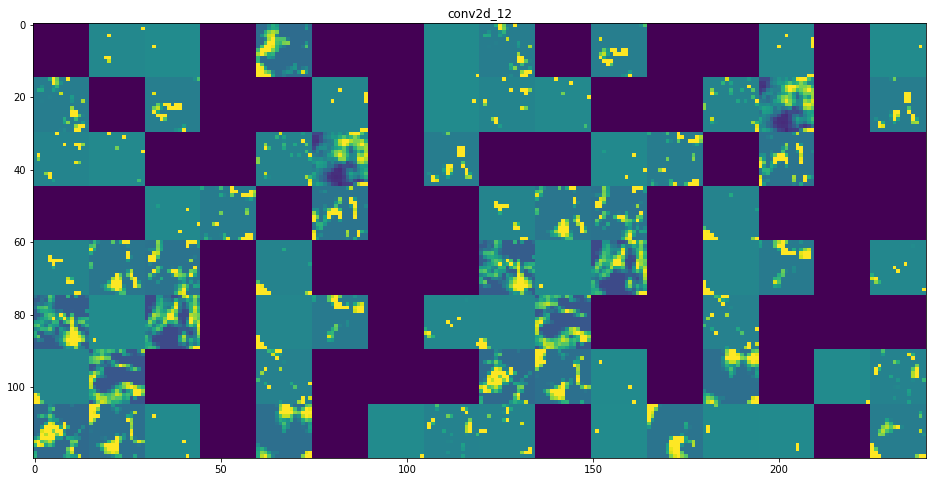

(1, 7, 7, 128) max_pooling2d_12
big_image.shape: (56, 112)


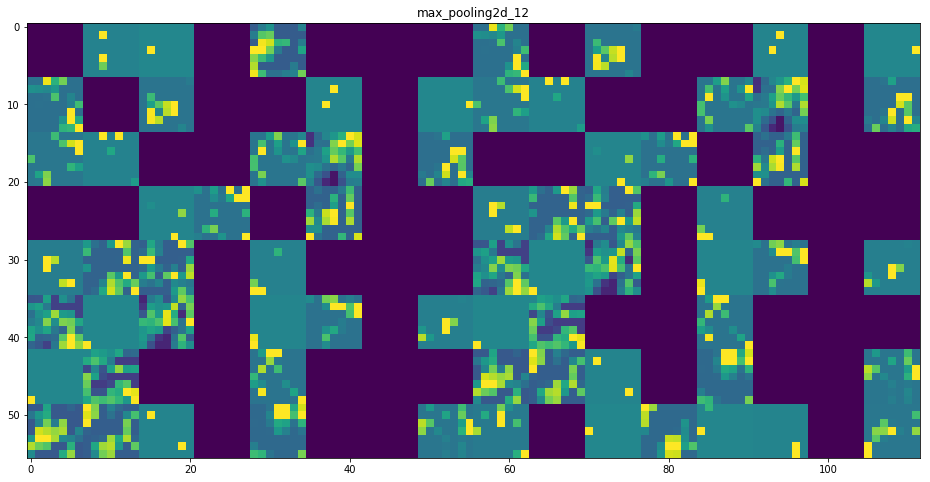

In [60]:
layer_names = [layer.name for layer in model.layers[:8]]

for act, name in zip(activations, layer_names):
    print(act.shape, name)
    
    # We can have 16 images in a single row
    num_cols = 16
    num_rows = int(act.shape[3] / num_cols)
    size = act.shape[1]
    
    big_image = np.zeros((num_rows * size, num_cols * size))
    print('big_image.shape:', big_image.shape)
    for row in range(num_rows):
        for col in range(num_cols):
#             print(f'row, col: ({row}, {col})')
#             print('Channel no. ', row * num_rows + col)

            # Post process images to make them more visible
            channel_image = act[0, :, :, row * num_rows + col]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             print('Indices: %d: %d, %d : %d.' % (col * size, (col + 1) * size, row * size, (row + 1) * size))
            big_image[row * size: (row + 1) * size, col * size: (col + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * big_image.shape[1], scale * big_image.shape[0]))
    plt.title(name)
    plt.grid(False)
    plt.imshow(big_image, aspect='auto', cmap='viridis')
    plt.show()
    
    
    

The above images show pretty much what was expected, the first few layers activate on detecting edges, simple shapes, colors, while the layers more further in the network detect bigger (and also more abstract) forms of the image. Also as the signal of the input image propagates through to the latest layers in the network, not many neurons activate - which can be seen by the blank images in the final few layers. This is simply because the patterns encoded by the filters are not found in the given input image. 

Funnily, as the author of "Deep Learning with Python" book says, this similar for people: we cannot accurately remember the details of the objects around us, even if we see them every day. We remember abstract representations of objects around us and we're still good in recognizing them, even without the details.

## References
- "Deep Learning with Python" book by Francois Chollet